# EDA

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from folium import Map, Marker
from folium.plugins import MarkerCluster

In [2]:
train = pd.read_csv("train.csv")
train.head()

id  vendor_id  ... store_and_fwd_flag trip_duration
0  id2875421          2  ...                  N           455
1  id2377394          1  ...                  N           663
2  id3858529          2  ...                  N          2124
3  id3504673          2  ...                  N           429
4  id2181028          2  ...                  N           435

[5 rows x 11 columns]

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


### Количество пропущенных значений:

In [4]:
train.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [5]:
train.drop(
	columns=["dropoff_datetime"], inplace=True
)  # есть только в обучающей выборке, поэтому удаляем
train.pickup_datetime = pd.to_datetime(train.pickup_datetime)

### Визуализация

График зависимости количества поездок от дня в году:

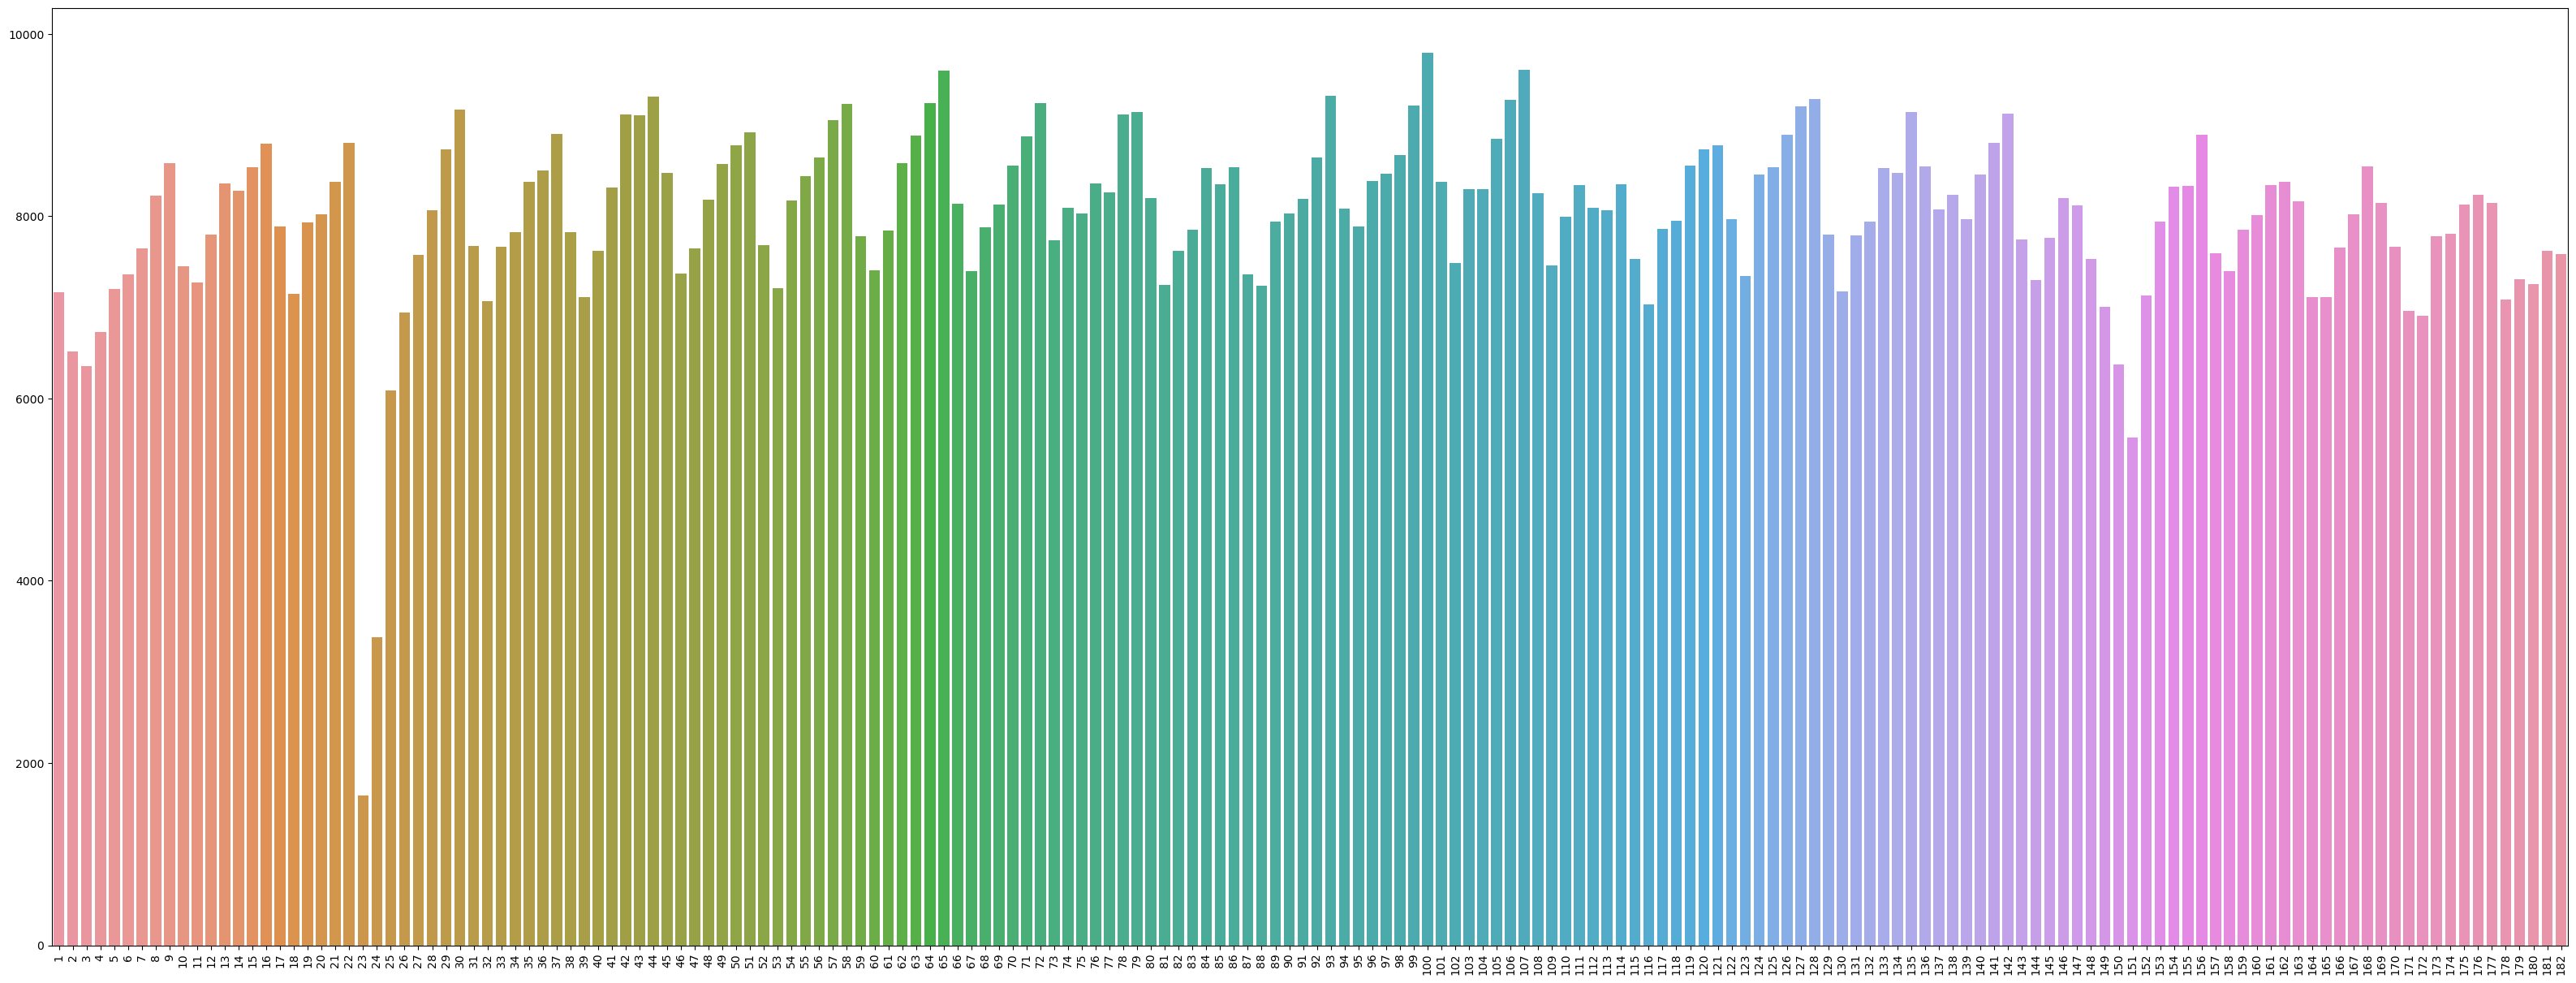

In [6]:
trips_per_day = train.pickup_datetime.dt.dayofyear.value_counts().sort_index()

fig, ax = plt.subplots(figsize=(40, 15))
chart = sns.barplot(x=trips_per_day.index, y=trips_per_day.values)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
None

Видно, что количество поездок сильно упало с 23 января до 25 января 2016. Все из-за того, что в Нью-Йорке тогда были сильнейшие снегопады, и на какое-то время был введен запрет на использование дорог

График зависимости количества поездок от дня недели:

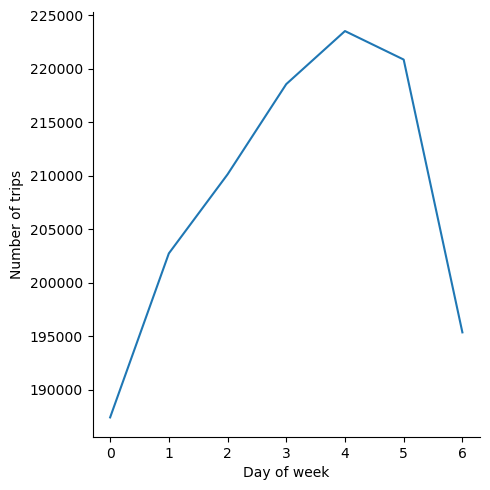

In [7]:
sns.relplot(
	x=sorted(train.pickup_datetime.dt.dayofweek.unique()),
	y=train.pickup_datetime.groupby(train["pickup_datetime"].dt.dayofweek).count(),
	kind="line",
).set_axis_labels("Day of week", "Number of trips")

Можно заметить, что самый большой спрос на такси приходится на Пятницу и Субботу. Это можно связать с тем, что некоторые люди в конце рабочей недели и на выходных любят пойти в рестораны, бары, клубы, кинотеатры и другие места развлечений, что может привести к увеличению спроса на такси, особенно вечером и ночью.

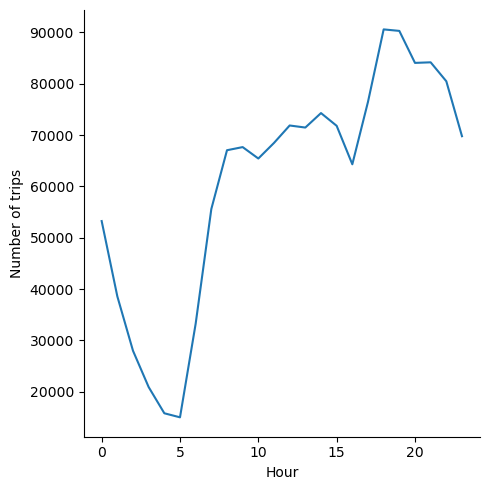

In [8]:
sns.relplot(
	x=sorted(train.pickup_datetime.dt.hour.unique()),
	y=train.pickup_datetime.groupby(train["pickup_datetime"].dt.hour).count(),
	kind="line",
).set_axis_labels("Hour", "Number of trips")

Наибольшее количество поездок на такси наблюдается в вечерние часы, примерно с 17:00 до 21:00, когда люди возвращаются с работы, обедают в ресторанах или отправляются на вечеринки и развлечения. Наименьшее количество с 3:00 до 5:00, когда люди наименее активно передвигаются

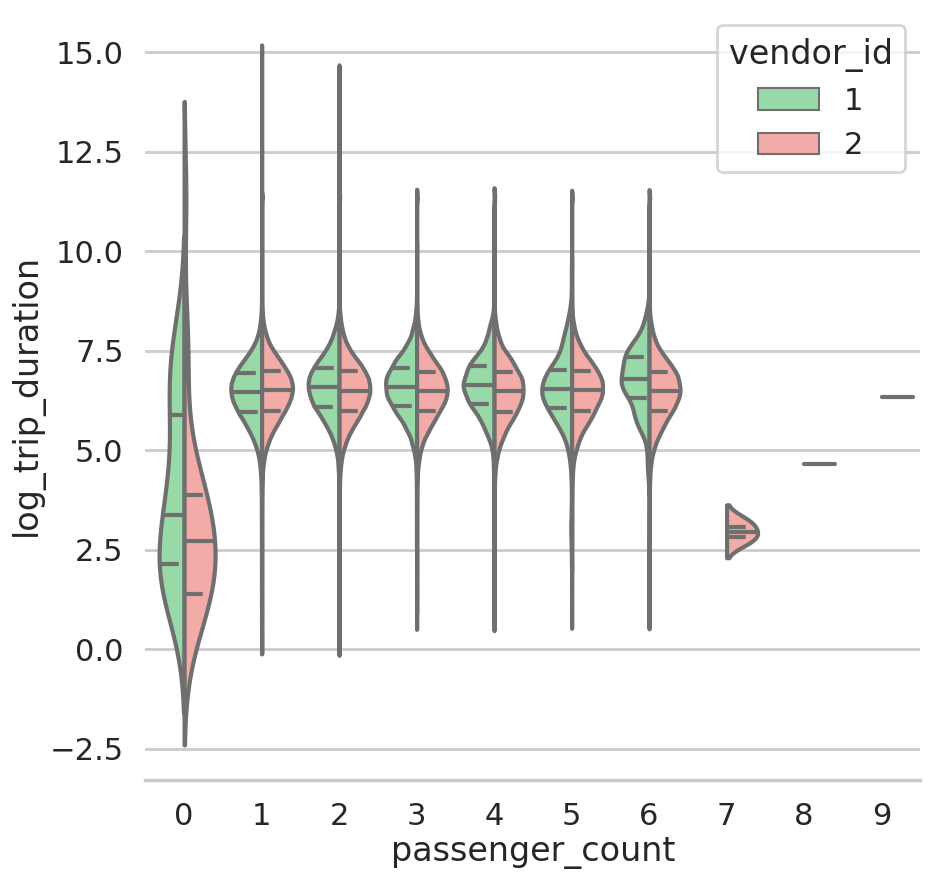

In [22]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.set_context("poster")
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
train["log_trip_duration"] = np.log(train["trip_duration"])
sns.violinplot(
	x="passenger_count",
	y="log_trip_duration",
	hue="vendor_id",
	data=train,
	split=True,
	inner="quart",
	palette={1: "g", 2: "r"},
)

sns.despine(left=True)

- У обоих поставщиков есть поездки с нулевым количеством пассажиров,
и некоторые из этих поездок также имеют отрицательное время, что в принципе невозможно, и следует удалить эти объекты из выборки.
- Распределения аналогичны для обоих поставщиков, но у одного поставщика больше поездок, чем у второго, для числа пассажиров 2 и 3.
- Очень мало рейсов с количеством пассажиров 7, 8 и 9.

In [8]:
def haversine_(lat1, lng1, lat2, lng2):
	"""function to calculate haversine distance between two coordinates"""
	lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
	avg_earth_radius = 6371  # in km
	lat = lat2 - lat1
	lng = lng2 - lng1
	d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
	h = 2 * avg_earth_radius * np.arcsin(np.sqrt(d))
	return h


def manhattan_distance_pd(lat1, lng1, lat2, lng2):
	"""function to calculate manhatten distance between pick_drop"""
	a = haversine_(lat1, lng1, lat1, lng2)
	b = haversine_(lat1, lng1, lat2, lng1)
	return a + b

In [9]:
train.loc[:, "hvsine_pick_drop"] = haversine_(
	train["pickup_latitude"].values,
	train["pickup_longitude"].values,
	train["dropoff_latitude"].values,
	train["dropoff_longitude"].values,
)
train.loc[:, "manhtn_pick_drop"] = manhattan_distance_pd(
	train["pickup_latitude"].values,
	train["pickup_longitude"].values,
	train["dropoff_latitude"].values,
	train["dropoff_longitude"].values,
)

### Матрица корреляции признаков

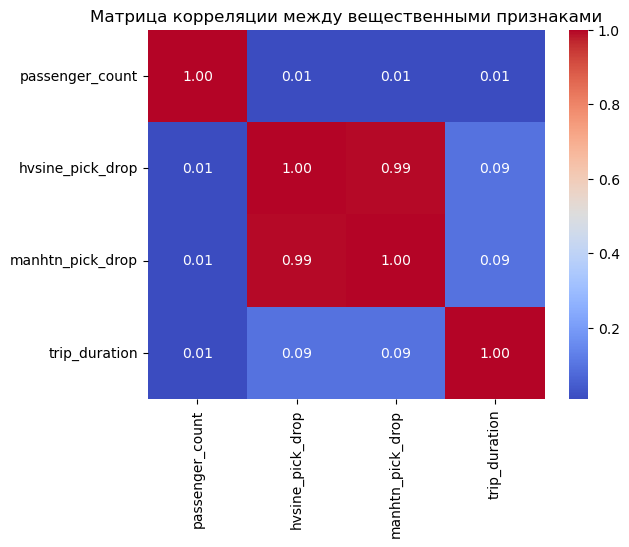

In [15]:
corr_matrix = train[
	["passenger_count", "hvsine_pick_drop", "manhtn_pick_drop", "trip_duration"]
].corr()

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Матрица корреляции между вещественными признаками")
plt.show()

### Карты с координатами старта и конца поездки

In [4]:
def show_markers_on_map(data, latitude_column, longitude_column):
	"""
	The function draws map with circles on it.
	The center of the map is the mean of coordinates passed in data.

	data: DataFrame that contains columns latitude_column and longitude_column
	latitude_column: string, the name of column for latitude coordinates
	longitude_column: string, the name of column for longitude coordinates
	"""

	location = (data[latitude_column].mean(), data[longitude_column].mean())
	m = Map(location=location)
	mc = MarkerCluster()

	for _, row in data.iterrows():
		mc.add_child(Marker([row[latitude_column], row[longitude_column]]))

	m.add_child(mc)

	return m

In [5]:
show_markers_on_map(train.sample(1000), "pickup_latitude", "pickup_longitude")

In [7]:
show_markers_on_map(train.sample(1000), "dropoff_latitude", "dropoff_longitude")

Очевидно, что большинство поездок совершается из Манхэттена